<a href="https://colab.research.google.com/github/gustavor10silva/precificacao_imoveis/blob/main/3_cruzamento_de_bases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importando bibliotecas

In [ ]:
import pandas as pd # para trabalhar com dataframes
!pip install geopandas
import geopandas as gpd # para trabalhar com enderecos geolocalizados

from geopy.geocoders import Nominatim # para converter endereco para location, com a latitude e longitude que precisamos
from geopy.extra.rate_limiter import RateLimiter # para fazer a conversao dos enderecos em larga escala
from tqdm import tqdm # para vermos uma barra de progresso na conversao dos enderecos, que é demorada
import shapely
from shapely.geometry import Point # para construirmos os pontos de longitude e latitude

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive") # para pegarmos o df_gold, que é a base de dados de imoveis depois da limpeza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.6 MB/s 
     |████████████████████████████████| 16.7 MB 30.2 MB/s 
     |████████████████████████████████| 6.3 MB 36.6 MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Dados do IBGE - Censo 2010

Os dados do IBGE que serão usados são os dados do Censo de 2010 do município de São Paulo.

Esses dados trazem, essencialmente, informações de infraestrutura, iluminação, saneamento, alfabetização, volume populacional, características da população e muitas outras variáveis separadas por setor censitário. Cada setor é identificado na coluna Cod_setor

As tabelas e variáveis de cada tabela podem ser consultada nesse [link](https://drive.google.com/file/d/1WVTqfKtHOOk5X1AWaSOn6NLaO7cix2m4/view).

Nesta seção do notebook, teremos uma subseção para cada tabela do Censo de 2021 que será utilizada para agregar informações na base de dados dos imóveis

## 2.1 Tabela Basico_SP1.csv

Essa tabela possui dados básicos. Usaremos as variáveis abaixo:

* Cod_setor

* Situação_setor

* V001

* V002

* V003

* V004

* V005

* V006

O significado dessas variáveis pode ser consultado na tabela:

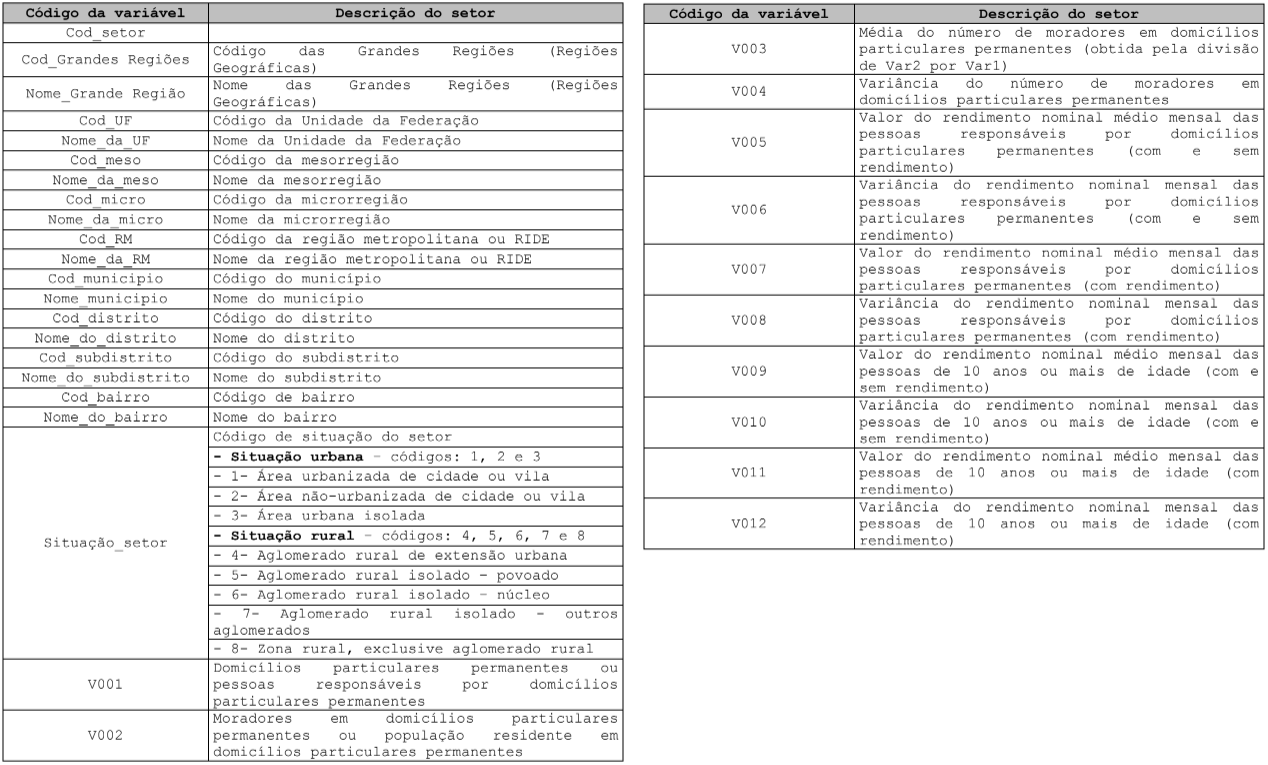

Vamos abrir o arquivo:

In [ ]:
basico_sp1 = pd.read_csv('https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv',
                      encoding='ISO-8859-1',
                      sep=';', thousands='.', decimal=',')
basico_sp1.dropna(how='all', axis=1, inplace=True)
basico_sp1

Cod_setor  Cod_Grandes Regiï¿½es Nome_Grande_Regiao  Cod_UF  \
0      355030801000001                      3   Regiï¿½o Sudeste      35   
1      355030801000002                      3   Regiï¿½o Sudeste      35   
2      355030801000003                      3   Regiï¿½o Sudeste      35   
3      355030801000004                      3   Regiï¿½o Sudeste      35   
4      355030801000005                      3   Regiï¿½o Sudeste      35   
...                ...                    ...                ...     ...   
18358  355030896000243                      3   Regiï¿½o Sudeste      35   
18359  355030896000244                      3   Regiï¿½o Sudeste      35   
18360  355030896000245                      3   Regiï¿½o Sudeste      35   
18361  355030896000246                      3   Regiï¿½o Sudeste      35   
18362  355030896000247                      3   Regiï¿½o Sudeste      35   

       Nome_da_UF   Cod_meso                  Nome_da_meso  Cod_micro  \
0      Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
1      Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
2      Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
3      Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
4      Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
...            ...       ...                           ...        ...   
18358  Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
18359  Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
18360  Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
18361  Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   
18362  Sï¿½o Paulo      3515  Metropolitana de Sï¿½o Paulo      35061   

      Nome_da_micro  Cod_RM  ...  V003  V004     V005        V006     V007  \
0       Sï¿½o Paulo      20  ...  3.01  2.32  2091.32  8532451.78  2164.55   
1       Sï¿½o Paulo      20  ...  2.98  2.09  1650.09  3983441.31  1717.44   
2       Sï¿½o Paulo      20  ...  3.31  3.08  1280.43  5474593.06  2349.53   
3       Sï¿½o Paulo      20  ...  3.16  2.26  1119.59  3572955.10  1859.13   
4       Sï¿½o Paulo      20  ...  3.14  2.35  1416.90  2240207.58  1581.66   
...             ...     ...  ...   ...   ...      ...         ...      ...   
18358   Sï¿½o Paulo      20  ...  3.50  2.61   772.09   168751.10   814.52   
18359   Sï¿½o Paulo      20  ...  3.87  2.49   692.50   239941.27   812.93   
18360   Sï¿½o Paulo      20  ...  3.90  2.54   630.06   329705.22   843.31   
18361   Sï¿½o Paulo      20  ...  4.29  4.21   597.37   349101.00   908.00   
18362   Sï¿½o Paulo      20  ...  3.77  3.28   630.13   183904.29   790.88   

             V008     V009        V010     V011        V012  
0      8673276.78  1227.41  4285771.99  1713.75  5152087.86  
1      4030519.99  1045.78  2572133.32  1468.08  2991546.94  
2      7553913.02   902.97  2735492.52  1786.79  3837674.74  
3      4567289.50   869.09  2122409.02  1567.41  2735383.24  
4      2240109.39   917.71  1570047.75  1356.35  1725877.85  
...           ...      ...         ...      ...         ...  
18358   143188.21   467.46   191332.48   699.95   123399.08  
18359   182516.20   439.33   194034.99   702.10   124952.38  
18360   260395.90   347.60   228162.66   767.50   181129.99  
18361   244391.67   397.76   436942.16   854.20   550319.43  
18362   102860.11   431.82   186963.45   728.70    98771.74  

[18363 rows x 33 columns]

In [ ]:
basico_sp1.columns

Index(['Cod_setor', 'Cod_Grandes Regiï¿½es', 'Nome_Grande_Regiao', 'Cod_UF',
       'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro',
       'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio',
       'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito',
       'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro', 'Situacao_setor',
       'Tipo_setor', 'V001', 'V002', 'V003', 'V004', 'V005', 'V006', 'V007',
       'V008', 'V009', 'V010', 'V011', 'V012'],
      dtype='object')

Agora, segue a seleção de variáveis:

In [ ]:
basico_sp1 = basico_sp1[['Cod_setor', 'Situacao_setor', 'V001', 'V002', 'V003', 'V004', 'V005', 'V006']]
basico_sp1.head()

Cod_setor  Situacao_setor   V001   V002  V003  V004     V005  \
0  355030801000001               1  266.0  800.0  3.01  2.32  2091.32   
1  355030801000002               1  306.0  913.0  2.98  2.09  1650.09   
2  355030801000003               1  189.0  625.0  3.31  3.08  1280.43   
3  355030801000004               1  181.0  572.0  3.16  2.26  1119.59   
4  355030801000005               1  240.0  754.0  3.14  2.35  1416.90   

         V006  
0  8532451.78  
1  3983441.31  
2  5474593.06  
3  3572955.10  
4  2240207.58

In [ ]:
basico_sp1.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/basico_sp1_tratado.csv')

## 2.2 Tabela Domicilio01_SP1.csv

As variáveis que serão utilizadas dessa tabela são:

* **Cod_setor:** código do setor censitário

* **V001:** Domicílios particulares e domicílios coletivos

* **V002:** Domicílios particulares permanentes

* **V012:** Domicílios particulares permanentes com abastecimento de água da rede geral

* **V017:** Domicílios particulares permanentes com banheiro de uso exclusivo dos moradores ou sanitário e esgotamento sanitário via rede geral de esgoto ou pluvial

* **V023:** Domicílios particulares permanentes sem banheiro de uso exclusivo dos moradores e nem sanitário

* **V035:** Domicílios particulares permanentes com lixo coletado

* **V043:** Domicílios particulares permanentes com energia elétrica

In [ ]:
domicilio01_sp1 = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Base informaçoes setores2010 universo SP_Capital/CSV/Domicilio01_SP1.csv',
                              encoding='ISO-8859-1',
                              sep=';', thousands='.', decimal=',')
domicilio01_sp1.head()

Cod_setor  Situacao_setor  V001  V002 V003 V004 V005 V006 V007 V008  \
0  355030801000001               1   268   266  203   20   11  136    7  116   
1  355030801000002               1   306   306  298    8    0  194   10   85   
2  355030801000003               1   189   189  177    1    7  135    1   50   
3  355030801000004               1   181   181  154    4   23   76    2   87   
4  355030801000005               1   240   240  226    1   12  105    4  112   

   ... V233 V234 V235 V236 V237 V238 V239 V240 V241 Unnamed: 243  
0  ...    0    1    1    0    0    0    0    0    0          NaN  
1  ...    0    0    0    0    0    0    0    0    0          NaN  
2  ...    0    0    0    0    0    0    0    0    0          NaN  
3  ...    0    0    0    0    0    0    0    0    0          NaN  
4  ...    0    0    0    0    0    0    0    0    0          NaN  

[5 rows x 244 columns]

In [ ]:
domicilio01_sp1 = domicilio01_sp1[['Cod_setor', 'V001', 'V002', 'V012', 'V017', 'V023', 'V035', 'V043']]
domicilio01_sp1.head()

Cod_setor  V001  V002 V012 V017 V023 V035 V043
0  355030801000001   268   266  266  266    0  265  266
1  355030801000002   306   306  306  306    0  306  306
2  355030801000003   189   189  189  187    0  189  189
3  355030801000004   181   181  181  181    0  181  181
4  355030801000005   240   240  240  240    0  240  240

In [ ]:
domicilio01_sp1.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/Domicilio01_SP1_tratado.csv')

## 2.3 Tabela Pessoa01_SP1.csv

As variáveis que serão utilizadas dessa tabela são:

* **Cod_setor**

* **V001:** Pessoas alfabetizadas com 5 ou mais anos de idade

In [ ]:
pessoa01_sp1 = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Base informaçoes setores2010 universo SP_Capital/CSV/Pessoa01_SP1.csv',
                              encoding='ISO-8859-1',
                              sep=';', thousands='.', decimal=',')
pessoa01_sp1.head()

Cod_setor  Situacao_setor  V001 V002 V003 V004 V005 V006 V007 V008  \
0  355030801000001               1   742    1    6    2    1    7    7   12   
1  355030801000002               1   833    5   10    6   12   10   12   11   
2  355030801000003               1   575    3    6    6    7    2    6    8   
3  355030801000004               1   530    1    5    9    5    6    6    5   
4  355030801000005               1   678    3    8    4    2   11   10    8   

   ... V076 V077 V078 V079 V080 V081 V082 V083 V084 V085  
0  ...    6   31  266  152  201   21   23   18   36    6  
1  ...    6   32  297  182  237   13   18   10   29    3  
2  ...    2   19  185  109  143   32   18   19   37    1  
3  ...    2   17  178  100  162   10   11   22   16    3  
4  ...    2   22  232  133  206   17   15   14   25    4  

[5 rows x 87 columns]

In [ ]:
pessoa01_sp1 = pessoa01_sp1[['Cod_setor', 'V001']]
pessoa01_sp1.head()

Cod_setor  V001
0  355030801000001   742
1  355030801000002   833
2  355030801000003   575
3  355030801000004   530
4  355030801000005   678

In [ ]:
pessoa01_sp1.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/Pessoa01_sp1_tratado.csv')

## 2.4 Tabela Pessoa03_SP1.csv

As variáveis que serão utilizadas dessa tabela são:

* **Cod_setor**

* **V001:** Pessoas Residentes

In [ ]:
pessoa03_sp1 = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Base informaçoes setores2010 universo SP_Capital/CSV/Pessoa03_SP1.csv',
                              encoding='ISO-8859-1',
                              sep=';', thousands='.', decimal=',')
pessoa03_sp1.head()

Cod_setor  Situacao_setor  V001 V002 V003 V004 V005 V006 V007 V008  \
0  355030801000001               1   806  661   23    3  119    0   29    0   
1  355030801000002               1   913  730   16    4  163    0   43    0   
2  355030801000003               1   625  521   25    8   71    0   31    1   
3  355030801000004               1   572  430   26    8  108    0   24    3   
4  355030801000005               1   754  580   28   23  123    0   38    0   

   ... V242 V243 V244 V245 V246 V247 V248 V249 V250 V251  
0  ...   57    1    0    5    0    2    0    0    2    0  
1  ...   53    2    1    8    0    5    1    0    1    0  
2  ...   33    2    1    4    0    3    0    0    2    0  
3  ...   25    1    1    1    0    3    0    0    1    0  
4  ...   33    1    1    2    0    6    0    0    1    0  

[5 rows x 253 columns]

In [ ]:
pessoa03_sp1 = pessoa03_sp1[['Cod_setor', 'V001']]
pessoa03_sp1.head()

Cod_setor  V001
0  355030801000001   806
1  355030801000002   913
2  355030801000003   625
3  355030801000004   572
4  355030801000005   754

In [ ]:
pessoa03_sp1.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/Pessoa03_sp1_tratado.csv')

## 2.5 Consolidado do IBGE

Nesta subseção, juntaremos todos os dados do IBGE em uma única tabela. Vamos começar importando as tabelas que construímos nas subseções anteriores:

In [ ]:
basico_sp1_tratado = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/basico_sp1_tratado.csv')
domicilio01_sp1_tratado = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Domicilio01_SP1_tratado.csv')
pessoa01_sp1_tratado = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Pessoa01_sp1_tratado.csv')
pessoa03_sp1_tratado = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/Pessoa03_sp1_tratado.csv')

Vejamos como está o dataframe basico_sp1_tratado:

In [ ]:
basico_sp1_tratado.head()

Unnamed: 0        Cod_setor  Situacao_setor   V001   V002  V003  V004  \
0           0  355030801000001               1  266.0  800.0  3.01  2.32   
1           1  355030801000002               1  306.0  913.0  2.98  2.09   
2           2  355030801000003               1  189.0  625.0  3.31  3.08   
3           3  355030801000004               1  181.0  572.0  3.16  2.26   
4           4  355030801000005               1  240.0  754.0  3.14  2.35   

      V005        V006  
0  2091.32  8532451.78  
1  1650.09  3983441.31  
2  1280.43  5474593.06  
3  1119.59  3572955.10  
4  1416.90  2240207.58

Vamos remover a coluna 'Unnamed: 0' e renomear as outras colunas, pois os nomes V001, V002 etc estão em todas as tabelas que obtemos do IBGE:

In [ ]:
basico_sp1_tratado.drop(columns = ['Unnamed: 0'], inplace = True)
basico_sp1_tratado.head()

Cod_setor  Situacao_setor   V001   V002  V003  V004     V005  \
0  355030801000001               1  266.0  800.0  3.01  2.32  2091.32   
1  355030801000002               1  306.0  913.0  2.98  2.09  1650.09   
2  355030801000003               1  189.0  625.0  3.31  3.08  1280.43   
3  355030801000004               1  181.0  572.0  3.16  2.26  1119.59   
4  355030801000005               1  240.0  754.0  3.14  2.35  1416.90   

         V006  
0  8532451.78  
1  3983441.31  
2  5474593.06  
3  3572955.10  
4  2240207.58

In [ ]:
basico_sp1_tratado.rename(columns={'Cod_setor': 'basico_sp1_Cod_setor',
                                   'Situacao_setor': 'basico_sp1_Situacao_setor',
                                   'V001': 'basico_sp1_V001',
                                   'V002': 'basico_sp1_V002',
                                   'V003': 'basico_sp1_V003',
                                   'V004': 'basico_sp1_V004',
                                   'V005': 'basico_sp1_V005',
                                   'V006': 'basico_sp1_V006'}, inplace = True)
basico_sp1_tratado.head()

basico_sp1_Cod_setor  basico_sp1_Situacao_setor  basico_sp1_V001  \
0       355030801000001                          1            266.0   
1       355030801000002                          1            306.0   
2       355030801000003                          1            189.0   
3       355030801000004                          1            181.0   
4       355030801000005                          1            240.0   

   basico_sp1_V002  basico_sp1_V003  basico_sp1_V004  basico_sp1_V005  \
0            800.0             3.01             2.32          2091.32   
1            913.0             2.98             2.09          1650.09   
2            625.0             3.31             3.08          1280.43   
3            572.0             3.16             2.26          1119.59   
4            754.0             3.14             2.35          1416.90   

   basico_sp1_V006  
0       8532451.78  
1       3983441.31  
2       5474593.06  
3       3572955.10  
4       2240207.58

Agora, vamos fazer o mesmo com os outros dataframes. Começando pela tabela domicilio01_sp1_tratado:

In [ ]:
domicilio01_sp1_tratado.drop(columns = ['Unnamed: 0'], inplace = True)
domicilio01_sp1_tratado.head()

Cod_setor  V001  V002 V012 V017 V023 V035 V043
0  355030801000001   268   266  266  266    0  265  266
1  355030801000002   306   306  306  306    0  306  306
2  355030801000003   189   189  189  187    0  189  189
3  355030801000004   181   181  181  181    0  181  181
4  355030801000005   240   240  240  240    0  240  240

In [ ]:
domicilio01_sp1_tratado.rename(columns={'Cod_setor': 'domicilio01_sp1_Cod_setor',
                                        'V001': 'domicilio01_sp1_V001',
                                        'V002': 'domicilio01_sp1_V002',
                                        'V0012': 'domicilio01_sp1_V012',
                                        'V017': 'domicilio01_sp1_V017',
                                        'V023': 'domicilio01_sp1_V023',
                                        'V035': 'domicilio01_sp1_V035',
                                        'V043': 'domicilio01_sp1_V043'}, inplace = True)
domicilio01_sp1_tratado.head()

domicilio01_sp1_Cod_setor  domicilio01_sp1_V001  domicilio01_sp1_V002 V012  \
0            355030801000001                   268                   266  266   
1            355030801000002                   306                   306  306   
2            355030801000003                   189                   189  189   
3            355030801000004                   181                   181  181   
4            355030801000005                   240                   240  240   

  domicilio01_sp1_V017 domicilio01_sp1_V023 domicilio01_sp1_V035  \
0                  266                    0                  265   
1                  306                    0                  306   
2                  187                    0                  189   
3                  181                    0                  181   
4                  240                    0                  240   

  domicilio01_sp1_V043  
0                  266  
1                  306  
2                  189  
3                  181  
4                  240

Fazendo o mesmo com a tabela pessoa01_sp1_tratado:

In [ ]:
pessoa01_sp1_tratado.drop(columns = ['Unnamed: 0'], inplace = True)
pessoa01_sp1_tratado.head()

Cod_setor  V001
0  355030801000001   742
1  355030801000002   833
2  355030801000003   575
3  355030801000004   530
4  355030801000005   678

In [ ]:
pessoa01_sp1_tratado.rename(columns={'Cod_setor': 'pessoa01_sp1_Cod_setor',
                                     'V001': 'pessoa01_sp1_V001'}, inplace = True)
pessoa01_sp1_tratado.head()

pessoa01_sp1_Cod_setor  pessoa01_sp1_V001
0         355030801000001                742
1         355030801000002                833
2         355030801000003                575
3         355030801000004                530
4         355030801000005                678

Fazendo o mesmo com a tabela pessoa03_sp1_tratado:

In [ ]:
pessoa03_sp1_tratado.drop(columns = ['Unnamed: 0'], inplace = True)
pessoa03_sp1_tratado.head()

Cod_setor  V001
0  355030801000001   806
1  355030801000002   913
2  355030801000003   625
3  355030801000004   572
4  355030801000005   754

In [ ]:
pessoa03_sp1_tratado.rename(columns={'Cod_setor': 'pessoa03_sp1_Cod_setor',
                                     'V001': 'pessoa03_sp1_V001'}, inplace = True)
pessoa03_sp1_tratado.head()

pessoa03_sp1_Cod_setor  pessoa03_sp1_V001
0         355030801000001                806
1         355030801000002                913
2         355030801000003                625
3         355030801000004                572
4         355030801000005                754

Agora, vamos juntar todas as tabelas no dataframe dados_ibge:

In [ ]:
dados_ibge = pd.concat([basico_sp1_tratado, domicilio01_sp1_tratado, pessoa01_sp1_tratado, pessoa03_sp1_tratado], axis=1, join="inner")
dados_ibge.head()

basico_sp1_Cod_setor  basico_sp1_Situacao_setor  basico_sp1_V001  \
0       355030801000001                          1            266.0   
1       355030801000002                          1            306.0   
2       355030801000003                          1            189.0   
3       355030801000004                          1            181.0   
4       355030801000005                          1            240.0   

   basico_sp1_V002  basico_sp1_V003  basico_sp1_V004  basico_sp1_V005  \
0            800.0             3.01             2.32          2091.32   
1            913.0             2.98             2.09          1650.09   
2            625.0             3.31             3.08          1280.43   
3            572.0             3.16             2.26          1119.59   
4            754.0             3.14             2.35          1416.90   

   basico_sp1_V006  domicilio01_sp1_Cod_setor  domicilio01_sp1_V001  \
0       8532451.78            355030801000001                   268   
1       3983441.31            355030801000002                   306   
2       5474593.06            355030801000003                   189   
3       3572955.10            355030801000004                   181   
4       2240207.58            355030801000005                   240   

   domicilio01_sp1_V002 V012 domicilio01_sp1_V017 domicilio01_sp1_V023  \
0                   266  266                  266                    0   
1                   306  306                  306                    0   
2                   189  189                  187                    0   
3                   181  181                  181                    0   
4                   240  240                  240                    0   

  domicilio01_sp1_V035 domicilio01_sp1_V043  pessoa01_sp1_Cod_setor  \
0                  265                  266         355030801000001   
1                  306                  306         355030801000002   
2                  189                  189         355030801000003   
3                  181                  181         355030801000004   
4                  240                  240         355030801000005   

   pessoa01_sp1_V001  pessoa03_sp1_Cod_setor  pessoa03_sp1_V001  
0                742         355030801000001                806  
1                833         355030801000002                913  
2                575         355030801000003                625  
3                530         355030801000004                572  
4                678         355030801000005                754

Note que todas as tabelas possuem 18363 linhas, incluindo a tabela final dados_ibge. Isso significa que todas possuem a mesma quantidade de setores sensitários, que são os setores do município de SP.

In [ ]:
len(basico_sp1_tratado), len(domicilio01_sp1_tratado), len(pessoa01_sp1_tratado), len(pessoa03_sp1_tratado), len(dados_ibge)

(18363, 18363, 18363, 18363, 18363)

Agora, vamos salvar esse dataframe:

In [ ]:
dados_ibge.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/dados_ibge.csv')

# 3 Malha censitária de SP - Polígonos dos setores censitários

Primeiro, vamos construir a base setor_censo, com os polígonos e os códigos dos setores censitários do município de SP.

Para isso, precisaremos da malha censitária do município de São Paulo, que pode ser encontrada neste [link](https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/2020/Malha_de_setores_(kml)_por_municipios).

No link acima, pode ser encontrado o arquivo zip da malha censitária. O arquivo que vamos abrir no jupyter notebook é o .shp, mas os outros precisam estar na mesma pasta que ele.

Veja na imagem abaixo. O arquivo .shp e mais outros 4 arquivos estão na mesma pasta do drive para que eu possa abrir o .shp no notebook.

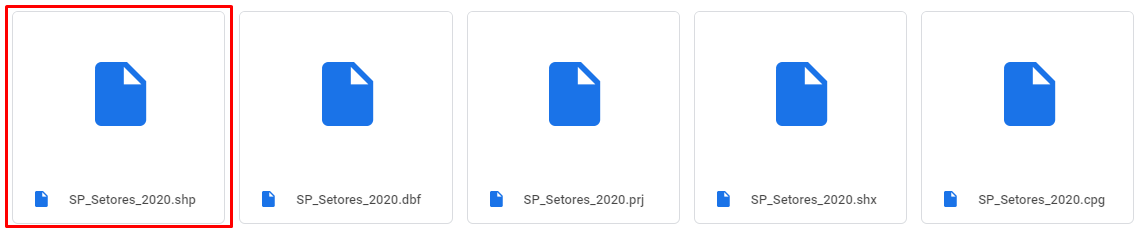

In [ ]:
setor_censo = gpd.read_file("/content/drive/MyDrive/Alura/imersao_dados4/SP_Setores_2020.shp")
setor_censo.head()

CD_SETOR CD_SIT                                        NM_SIT CD_UF  \
0  350010505000001      1  Área Urbana de Alta Densidade de Edificações    35   
1  350010505000002      1  Área Urbana de Alta Densidade de Edificações    35   
2  350010505000003      1  Área Urbana de Alta Densidade de Edificações    35   
3  350010505000004      1  Área Urbana de Alta Densidade de Edificações    35   
4  350010505000005      1  Área Urbana de Alta Densidade de Edificações    35   

       NM_UF SIGLA_UF   CD_MUN      NM_MUN    CD_DIST     NM_DIST  \
0  São Paulo       SP  3500105  Adamantina  350010505  Adamantina   
1  São Paulo       SP  3500105  Adamantina  350010505  Adamantina   
2  São Paulo       SP  3500105  Adamantina  350010505  Adamantina   
3  São Paulo       SP  3500105  Adamantina  350010505  Adamantina   
4  São Paulo       SP  3500105  Adamantina  350010505  Adamantina   

    CD_SUBDIST NM_SUBDIST                                           geometry  
0  35001050500       None  POLYGON ((-51.07255 -21.68865, -51.07237 -21.6...  
1  35001050500       None  POLYGON ((-51.07378 -21.68620, -51.07388 -21.6...  
2  35001050500       None  POLYGON ((-51.07138 -21.68313, -51.06965 -21.6...  
3  35001050500       None  POLYGON ((-51.06880 -21.68808, -51.06730 -21.6...  
4  35001050500       None  POLYGON ((-51.06969 -21.69442, -51.06928 -21.6...

Note que temos:

* Código do setor censitário na primeira coluna
* Polígono do setor censitário na última coluna

E isso é tudo o que precisamos para unir os dados dos imóveis com os dados do IBGE. Então vamos excluir as outras colunas e salvar o dataframe:

In [ ]:
setor_censo = setor_censo[['CD_SETOR', 'geometry']]
setor_censo.head()

CD_SETOR                                           geometry
0  350010505000001  POLYGON ((-51.07255 -21.68865, -51.07237 -21.6...
1  350010505000002  POLYGON ((-51.07378 -21.68620, -51.07388 -21.6...
2  350010505000003  POLYGON ((-51.07138 -21.68313, -51.06965 -21.6...
3  350010505000004  POLYGON ((-51.06880 -21.68808, -51.06730 -21.6...
4  350010505000005  POLYGON ((-51.06969 -21.69442, -51.06928 -21.6...

In [ ]:
#setor_censo.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/setor_censo.csv')

In [ ]:
#setor_censo.to_file('/content/drive/MyDrive/Alura/imersao_dados4/setor_censo.csv')

# 4 Convertendo endereços da base de imóveis df_gold em latitude e longitude

## 4.1 Construindo uma coluna de endereço completo

Agora, vamos obter as coordenadas de latitude e longitude dos endereços dos imóveis na base df_gold.

Primeiro, vamos carregar a base:

In [ ]:
df_gold = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_gold.csv')
df_gold.drop(columns = ['Unnamed: 0'], inplace = True)
df_gold

Rua             Bairro     Cidade  Metragem  Quartos  \
0         Rua Caramuru, 100               Saúde  São Paulo       380        9   
1       Alameda Franca, 587     Jardim Paulista  São Paulo       137        9   
2       Alameda Franca, 587     Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973   Rua Luís Botta, 1137   Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  
0             4      4  3700000  
1             2      1  2600000  
2             2      1  2600000  
3             2      1  2600000  
4             2      1  2600000  
...         ...    ...      ...  
8970          1      1   188682  
8971          1      1   188682  
8972          1      1   160000  
8973          1      1   147288  
8974          1      1   147288  

[8975 rows x 8 columns]

Agora, vamos construir uma coluna com o endereço completo, juntando as colunas de Rua, Bairro e Cidade:

In [ ]:
endereco = df_gold["Rua"] + " - " + df_gold["Bairro"] + ", " + df_gold["Cidade"]
endereco

0                   Rua Caramuru, 100  - Saúde, São Paulo
1       Alameda Franca, 587  - Jardim Paulista, São Paulo
2       Alameda Franca, 587  - Jardim Paulista, São Paulo
3             Alameda Franca - Jardim Paulista, São Paulo
4             Alameda Franca - Jardim Paulista, São Paulo
                              ...                        
8970                                                  NaN
8971                                                  NaN
8972    Rua Victória Simionato - Vila Paranaguá, São P...
8973    Rua Luís Botta, 1137  - Cidade São Mateus, São...
8974                                                  NaN
Length: 8975, dtype: object

Vamos adicionar o endereço completo na primeira coluna do dataframe:

In [ ]:
df_gold.insert(0, "endereco", endereco, allow_duplicates = True)
df_gold

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                                                NaN   
8971                                                NaN   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                                                NaN   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0         Rua Caramuru, 100               Saúde  São Paulo       380        9   
1       Alameda Franca, 587     Jardim Paulista  São Paulo       137        9   
2       Alameda Franca, 587     Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973   Rua Luís Botta, 1137   Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  
0             4      4  3700000  
1             2      1  2600000  
2             2      1  2600000  
3             2      1  2600000  
4             2      1  2600000  
...         ...    ...      ...  
8970          1      1   188682  
8971          1      1   188682  
8972          1      1   160000  
8973          1      1   147288  
8974          1      1   147288  

[8975 rows x 9 columns]

Note que nas linhas que não temos o dado da Rua, também ficamos sem o dado do Endereço. Nesses casos, vamos inserir no endereço a combinação de bairro e cidade:

In [ ]:
df_gold['endereco'].fillna(df_gold["Bairro"] + ", " + df_gold["Cidade"], inplace = True)
df_gold

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                        Vila Nova Curuçá, São Paulo   
8971                        Vila Nova Curuçá, São Paulo   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                       Cidade São Mateus, São Paulo   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0         Rua Caramuru, 100               Saúde  São Paulo       380        9   
1       Alameda Franca, 587     Jardim Paulista  São Paulo       137        9   
2       Alameda Franca, 587     Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973   Rua Luís Botta, 1137   Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  
0             4      4  3700000  
1             2      1  2600000  
2             2      1  2600000  
3             2      1  2600000  
4             2      1  2600000  
...         ...    ...      ...  
8970          1      1   188682  
8971          1      1   188682  
8972          1      1   160000  
8973          1      1   147288  
8974          1      1   147288  

[8975 rows x 9 columns]

Agora, mesmo nas linhas onde não temos a Rua, temos o endereço. Vamos contar quantos são os valores faltantes da coluna endereço:

In [ ]:
print(df_gold['endereco'].isnull().sum())

10


Ou seja, temos 8975 dados e apenas em 10 deles estamos sem endereço. Esse é um número ótimo. Isso significa que vamos conseguir transformar o endereço em point para praticamente todos os dados da nossa base.

## 4.2 Obtendo a latitude e a longitude do endereço

### 4.2.1 Exemplo

Esta seção foi baseada no vídeo [Como converter ENDEREÇOS em coordenadas LATITUDE e LONGITUDE | Python na Prática #18](https://www.youtube.com/watch?v=asSNKH_ee0M&t=389s&ab_channel=Programa%C3%A7%C3%A3oDin%C3%A2mica)

Para converter o endereço em latitude e longitude, usaremos a biblioteca geopy.geocoders.Nominatim

Com o Nominatim, conseguimos obter várias informações de um endereço. Por exemplo, considere o endereço do Parque Barigui, em Curitiba:

"Av. Cândido Hartmann, S/N - Bigorrilho, Curitiba - PR, 82025-160"

In [ ]:
locator = Nominatim( ) #user_agent="myGeocoder"
location = locator.geocode("Av. Cândido Hartmann, S/N - Bigorrilho, Curitiba - PR, 82025-160")
location

Location(Avenida Cândido Hartmann, Bigorrilho, Curitiba, Região Geográfica Imediata de Curitiba, Região Metropolitana de Curitiba, Região Geográfica Intermediária de Curitiba, Paraná, Região Sul, 80710-410, Brasil, (-25.4230874, -49.3064685, 0.0))

In [ ]:
location.address

'Avenida Cândido Hartmann, Bigorrilho, Curitiba, Região Geográfica Imediata de Curitiba, Região Metropolitana de Curitiba, Região Geográfica Intermediária de Curitiba, Paraná, Região Sul, 80710-410, Brasil'

Usando o método point, obtemos a latitude, a longitude e a altitude do endereço dado:

In [ ]:
location.point

Point(-25.4230874, -49.3064685, 0.0)

Para conferir o resultado, coloquei essas coordenadas de latitude e longitude no Google Maps:

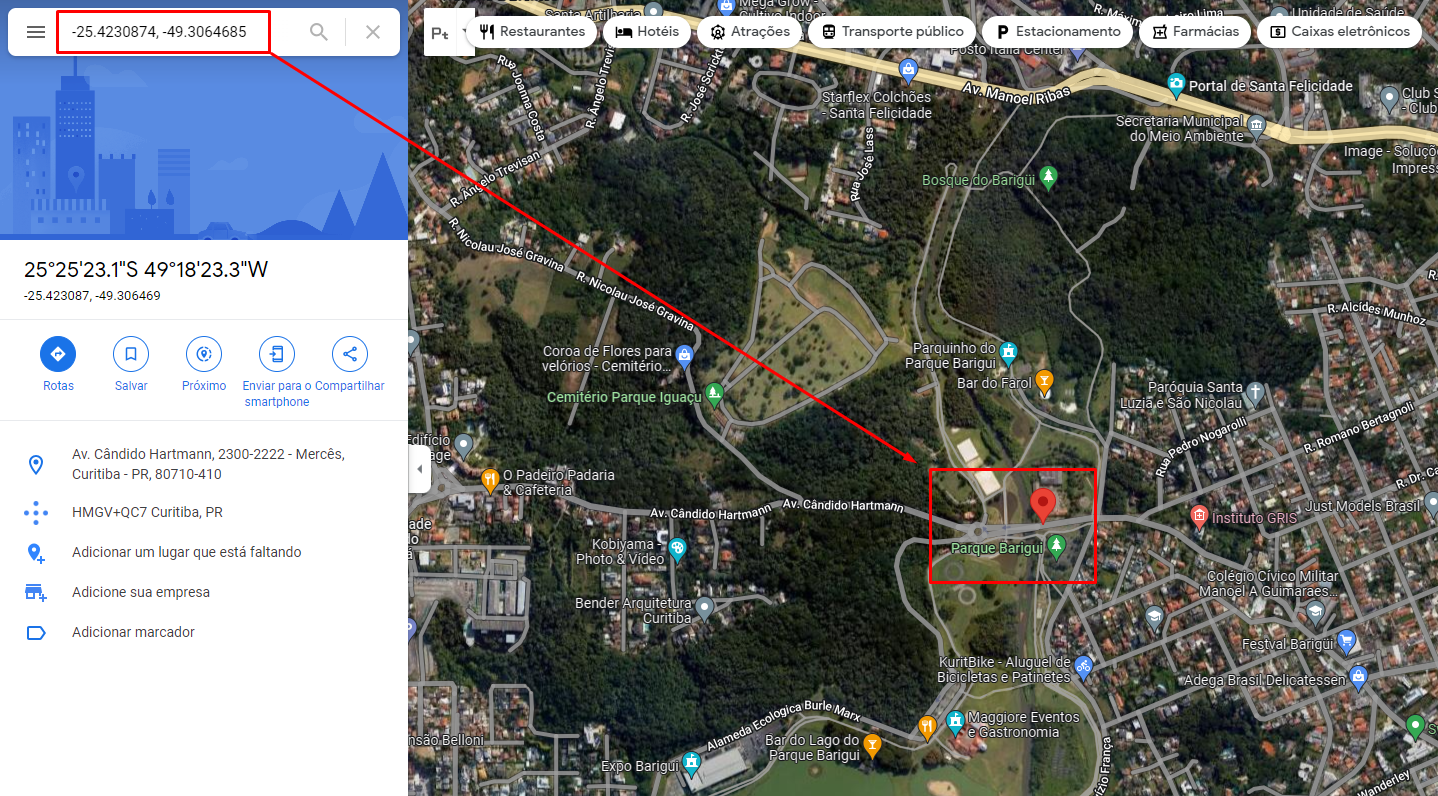

Veja que realmente funcionou.

### 4.2.2 Aplicação

Para usarmos isso na base de dados inteira, com 8975 linhas, usaremos o RateLimiter, pois nele conseguimos passar os parâmetros:

* min_delay_seconds: tempo mínimo de espera entre as requisições, para evitar erros;
* max_retries: quantidade máxima de tentativas extras de obter um mesmo endereço, caso dê erro na primeira tentativa

In [ ]:
locator = Nominatim()
geocode = RateLimiter(locator.geocode, min_delay_seconds = 0.1, max_retries = 1)

tqdm.pandas() # isso serve apenas para exibir a barra de progresso das requisições
endereco_geolocalizado = df_gold['endereco'].progress_apply(geocode) # armazenando os endereços geolozaclizados em uma variável. Se não quisermos a barra de progresso basta usar .apply em vez de .progress_apply

  1%|          | 64/8975 [00:32<1:11:58,  2.06it/s]WARNING:geopy:RateLimiter caught an error, retrying (0/1 tries). Called with (*('Vila Maria Alta, São Paulo',), **{}).
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/usr/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 1393, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/usr/lib/python3.7/urllib/request.py", line 1353, in do_open
    r = h.getresponse()
  File "/usr/lib/python3.7/http/client.py", line 1373, in getresponse
    response.begin()
  File "/usr/lib/python3.7/http/client

Vejamos como está a variável com o endereço geolocalizado:

In [ ]:
endereco_geolocalizado

0       (100, Rua Caramuru, Chácara Inglesa, Saúde, Sã...
1       (Alameda Franca, Cerqueira César, Jardim Pauli...
2       (Alameda Franca, Cerqueira César, Jardim Pauli...
3       (Alameda Franca, Cerqueira César, Jardim Pauli...
4       (Alameda Franca, Cerqueira César, Jardim Pauli...
                              ...                        
8970    (Nanno, Ville d'Anaunia, Comunità della Val di...
8971    (Nanno, Ville d'Anaunia, Comunità della Val di...
8972                                                 None
8973                                                 None
8974    (Nanno, Ville d'Anaunia, Comunità della Val di...
Name: endereco, Length: 8975, dtype: object

Vamos criar um dataframe df_gold_geo que possui os dados dos imóveis e a coluna do endereço geolocalizado:

In [ ]:
df_gold_geo = df_gold
df_gold_geo['endereco_geolocalizado'] = endereco_geolocalizado
df_gold_geo

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                        Vila Nova Curuçá, São Paulo   
8971                        Vila Nova Curuçá, São Paulo   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                       Cidade São Mateus, São Paulo   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0         Rua Caramuru, 100               Saúde  São Paulo       380        9   
1       Alameda Franca, 587     Jardim Paulista  São Paulo       137        9   
2       Alameda Franca, 587     Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973   Rua Luís Botta, 1137   Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  \
0             4      4  3700000   
1             2      1  2600000   
2             2      1  2600000   
3             2      1  2600000   
4             2      1  2600000   
...         ...    ...      ...   
8970          1      1   188682   
8971          1      1   188682   
8972          1      1   160000   
8973          1      1   147288   
8974          1      1   147288   

                                 endereco_geolocalizado  
0     (100, Rua Caramuru, Chácara Inglesa, Saúde, Sã...  
1     (Alameda Franca, Jardim Paulista, São Paulo, R...  
2     (Alameda Franca, Jardim Paulista, São Paulo, R...  
3     (Alameda Franca, Jardim Paulista, São Paulo, R...  
4     (Alameda Franca, Jardim Paulista, São Paulo, R...  
...                                                 ...  
8970  (Vila Nova Curuça, Vila Curuçá, São Paulo, Reg...  
8971  (Vila Nova Curuça, Vila Curuçá, São Paulo, Reg...  
8972                                               None  
8973                                               None  
8974  (Avenida São Paulo, Nova Cidade, Boa Esperança...  

[8975 rows x 10 columns]

Vamos contar quantos dados ficaram sem o endereço geolocalizado:

In [ ]:
sem_geoloc = df_gold_geo['endereco_geolocalizado'].isnull().sum()
porc = sem_geoloc * 100 / len(df_gold_geo)

print("Dados sem endereço geolocalizado")
print("Quantidade:", sem_geoloc)
print(f"Percentual: {porc:.2f}%")

Dados sem endereço geolocalizado
Quantidade: 3259
Percentual: 36.31%



Agora, vamos usar a coluna do endereço geolocalizado para obter a coluna com a latitude e a longitude do endereço, usando o método .point:

In [ ]:
locationx = locator.geocode(df_gold_geo['endereco_geolocalizado'][0])
locationx.point

Point(-23.604879631024357, -46.63654708002167, 0.0)

In [ ]:
1500%200

100

In [ ]:
import time

for i in range(890, len(df_gold_geo)):

    try:
      df_gold_geo['endereco_locator'][i] = locator.geocode(df_gold_geo['endereco_geolocalizado'][i])
      df_gold_geo['endereco_point'][i] = df_gold_geo['endereco_locator'][i].point

    except:
        pass

    if i % 200 == 0:
        print('sleeping 10 seconds')
        time.sleep(10)
    print(i)

df_gold_geo.head()

A saída de streaming foi truncada nas últimas 5000 linhas.
sleeping 10 seconds
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4

Unnamed: 0                                           endereco  \
0           0              Rua Caramuru, 100  - Saúde, São Paulo   
1           1  Alameda Franca, 587  - Jardim Paulista, São Paulo   
2           2  Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           3        Alameda Franca - Jardim Paulista, São Paulo   
4           4        Alameda Franca - Jardim Paulista, São Paulo   

                    Rua           Bairro     Cidade  Metragem  Quartos  \
0    Rua Caramuru, 100             Saúde  São Paulo       380        9   
1  Alameda Franca, 587   Jardim Paulista  São Paulo       137        9   
2  Alameda Franca, 587   Jardim Paulista  São Paulo       142        9   
3        Alameda Franca  Jardim Paulista  São Paulo       150        9   
4        Alameda Franca  Jardim Paulista  São Paulo       155        9   

   Banheiros  Vagas    Valor  \
0          4      4  3700000   
1          2      1  2600000   
2          2      1  2600000   
3          2      1  2600000   
4          2      1  2600000   

                              endereco_geolocalizado  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   

                         endereco_point  \
0  23 36m 17.5667s S, 46 38m 11.5695s W   
1  23 34m 2.55036s S, 46 39m 25.7126s W   
2  23 34m 2.55036s S, 46 39m 25.7126s W   
3  23 34m 2.55036s S, 46 39m 25.7126s W   
4  23 34m 2.55036s S, 46 39m 25.7126s W   

                                    endereco_locator  
0  (100, Rua Caramuru, Chácara Inglesa, Saúde, Sã...  
1  (Alameda Franca, Jardim Paulista, São Paulo, R...  
2  (Alameda Franca, Jardim Paulista, São Paulo, R...  
3  (Alameda Franca, Jardim Paulista, São Paulo, R...  
4  (Alameda Franca, Jardim Paulista, São Paulo, R...

Vejamos como é um elemento do tipo .point que estamos guardando no dataframe:

In [ ]:
df_gold_geo['endereco_point'][0]

Point(-23.604879631024357, -46.63654708002167, 0.0)

In [ ]:
df_gold_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   endereco                8965 non-null   object
 1   Rua                     6008 non-null   object
 2   Bairro                  8965 non-null   object
 3   Cidade                  8975 non-null   object
 4   Metragem                8975 non-null   int64 
 5   Quartos                 8975 non-null   int64 
 6   Banheiros               8975 non-null   int64 
 7   Vagas                   8975 non-null   int64 
 8   Valor                   8975 non-null   int64 
 9   endereco_geolocalizado  5716 non-null   object
 10  endereco_point          8975 non-null   object
 11  endereco_locator        8949 non-null   object
dtypes: int64(5), object(7)
memory usage: 841.5+ KB


Por fim, vamos salvar esse arquivo no drive. Ele também ficará disponível no github na pasta [arquivos do repositório deste projeto](https://github.com/gustavor10silva/alura_imersao_dados_4/tree/main/arquivos).

In [ ]:
df_gold_geo.drop(columns = ['Unnamed: 0'], inplace = True)
df_gold_geo.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_gold_geo_v3.csv')

### 4.2.3 Lidando com os casos com erro

Na subseção anterior, tivemos 3259 dados que ficaram sem o endereço geolocalizado. Tentei inserir esse endereço novamente e não consegui. Por isso, para esses casos, eu inseri o código do setor censitário manualmente.

Para fazer isso, segui os passos:

* Entrei no site do IBGE e baixei a malha do setor censitário do município de São Paulo (arquivo .kml);

* Abri a malha do setor censitário no Google Earth e abri a base de dados no Google Sheets;

* Para cada distrito da base de dados, localizei o distrito no mapa, coletei o código do setor censitário manualmente e inseri na base de dados no sheets.

# 5 Cruzando todas as bases

Queremos cruzar os dados do Censo de 2010 (dataframe dados_ibge) com os dados dos imóveis que já tratamos e inserimos as colunas de dados geográficos(dataframe df_gold_geo).

Para fazer esse cruzamento de dados, usaremos a tabela setor_censo com os polígonos dos setores censitários, conforme a lógica abaixo:

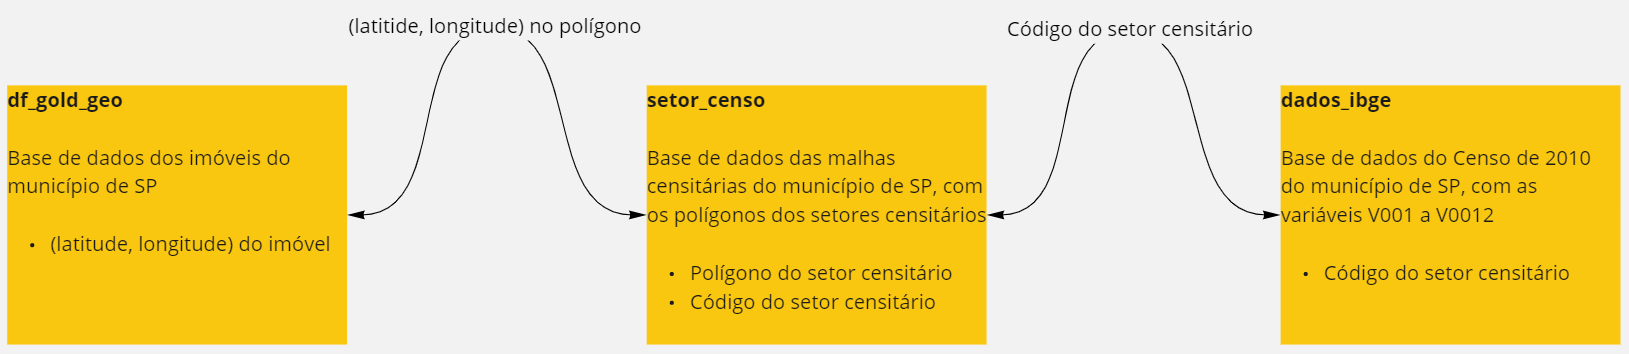

Ou seja, vamos fazer o seguinte:

* **Passo 1:** Conectar a base de imóveis df_gold_geo com a base setor_censo analisando se o ponto (latitude, longitude) está dentro do polígono que define o setor censitário
* **Passo 2:** Conectar essas bases com a base ibge_sp por meio do código do setor censitário

Com isso, teremos os dados dos imóveis junto com as variáveis do Censo 2010 no mesmo dataframe. Agora, vamos aos passos 1 e 2.

## 5.1 Conectando df_gold_geo com setor_censo usando os polígonos

Importando o dataframe df_gold_geo:

In [ ]:
df_gold_geo = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_gold_geo_v3.csv')
df_gold_geo.drop(columns = ['Unnamed: 0'], inplace = True)
df_gold_geo.head()

endereco                   Rua  \
0              Rua Caramuru, 100  - Saúde, São Paulo    Rua Caramuru, 100    
1  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
2  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
3        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   
4        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   

            Bairro     Cidade  Metragem  Quartos  Banheiros  Vagas    Valor  \
0            Saúde  São Paulo       380        9          4      4  3700000   
1  Jardim Paulista  São Paulo       137        9          2      1  2600000   
2  Jardim Paulista  São Paulo       142        9          2      1  2600000   
3  Jardim Paulista  São Paulo       150        9          2      1  2600000   
4  Jardim Paulista  São Paulo       155        9          2      1  2600000   

                              endereco_geolocalizado  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   

                         endereco_point  \
0  23 36m 17.5667s S, 46 38m 11.5695s W   
1  23 34m 2.55036s S, 46 39m 25.7126s W   
2  23 34m 2.55036s S, 46 39m 25.7126s W   
3  23 34m 2.55036s S, 46 39m 25.7126s W   
4  23 34m 2.55036s S, 46 39m 25.7126s W   

                                    endereco_locator  
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...  
1  Alameda Franca, Jardim Paulista, São Paulo, Re...  
2  Alameda Franca, Jardim Paulista, São Paulo, Re...  
3  Alameda Franca, Jardim Paulista, São Paulo, Re...  
4  Alameda Franca, Jardim Paulista, São Paulo, Re...

Importando o dataframe setor_censo:

In [ ]:
setor_censo = gpd.read_file("/content/drive/MyDrive/Alura/imersao_dados4/SP_Setores_2020.shp")
setor_censo = setor_censo[['CD_SETOR', 'geometry']]
setor_censo.head()

CD_SETOR                                           geometry
0  350010505000001  POLYGON ((-51.07255 -21.68865, -51.07237 -21.6...
1  350010505000002  POLYGON ((-51.07378 -21.68620, -51.07388 -21.6...
2  350010505000003  POLYGON ((-51.07138 -21.68313, -51.06965 -21.6...
3  350010505000004  POLYGON ((-51.06880 -21.68808, -51.06730 -21.6...
4  350010505000005  POLYGON ((-51.06969 -21.69442, -51.06928 -21.6...

Veja que o point está em formato de string na ordem:

'(latitude, longitude, altitude)'

In [ ]:
df_gold_geo['endereco_point'][0].split(' ')

['23', '36m', '17.5667s', 'S,', '46', '38m', '11.5695s', 'W']

Precisamos que o point esteja no formato

'(longitude, latitude)'

então vamos criar as colunas de latitude, longitude e uma coluna para inserirmos o point no formato que precisamos:

In [ ]:
df_gold_geo['latitude'] = ''
df_gold_geo['longitude'] = ''
df_gold_geo['point'] = ''

df_gold_geo.endereco_point.astype(str)

for i in range(len(df_gold_geo)):
    try:
        # pegando o sinal da latitude e da longitude
        latitude_sinal = df_gold_geo['endereco_point'][i].split(' ')[3].replace(',', '')
        longitude_sinal = df_gold_geo['endereco_point'][i].split(' ')[7]

        # calculando a latitude em graus

        latitude_graus = float(df_gold_geo['endereco_point'][i].split(' ')[0])
        latitude_minutos = float(df_gold_geo['endereco_point'][i].split(' ')[1].replace('m', ''))
        latitude_segundos = float(df_gold_geo['endereco_point'][i].split(' ')[2].replace('s', ''))

        x_min_lat = latitude_minutos/60
        x_sec_lat = latitude_segundos/3600

        latitude = latitude_graus + x_min_lat + x_sec_lat
        
        # calculando a longitude em graus

        longitude_graus = float(df_gold_geo['endereco_point'][i].split(' ')[4])
        longitude_minutos = float(df_gold_geo['endereco_point'][i].split(' ')[5].replace('m', ''))
        longitude_segundos = float(df_gold_geo['endereco_point'][i].split(' ')[6].replace('s', ''))

        x_min_long = longitude_minutos/60
        x_sec_long = longitude_segundos/3600

        longitude = longitude_graus + x_min_long + x_sec_long

        # inserindo o sinal na latitude e na longitude

        if latitude_sinal == 'S':
            df_gold_geo['latitude'][i] = - latitude
        else:
            df_gold_geo['latitude'][i] = latitude
        if longitude_sinal == 'W': 
            df_gold_geo['longitude'][i] = - longitude
        else:
            df_gold_geo['longitude'][i] = longitude

    except:
        pass

    try:
        df_gold_geo['point'][i] = Point(df_gold_geo['longitude'][i], df_gold_geo['latitude'][i])
    except:
        pass

In [ ]:
df_gold_geo.head()

endereco                   Rua  \
0              Rua Caramuru, 100  - Saúde, São Paulo    Rua Caramuru, 100    
1  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
2  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
3        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   
4        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   

            Bairro     Cidade  Metragem  Quartos  Banheiros  Vagas    Valor  \
0            Saúde  São Paulo       380        9          4      4  3700000   
1  Jardim Paulista  São Paulo       137        9          2      1  2600000   
2  Jardim Paulista  São Paulo       142        9          2      1  2600000   
3  Jardim Paulista  São Paulo       150        9          2      1  2600000   
4  Jardim Paulista  São Paulo       155        9          2      1  2600000   

                              endereco_geolocalizado  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   

                         endereco_point  \
0  23 36m 17.5667s S, 46 38m 11.5695s W   
1  23 34m 2.55036s S, 46 39m 25.7126s W   
2  23 34m 2.55036s S, 46 39m 25.7126s W   
3  23 34m 2.55036s S, 46 39m 25.7126s W   
4  23 34m 2.55036s S, 46 39m 25.7126s W   

                                    endereco_locator latitude longitude  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   -23.60    -46.64   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   -23.57    -46.66   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   -23.57    -46.66   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   -23.57    -46.66   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   -23.57    -46.66   

                                           point  
0  POINT (-46.63654708333333 -23.60487963888889)  
1        POINT (-46.657142388888886 -23.5673751)  
2        POINT (-46.657142388888886 -23.5673751)  
3        POINT (-46.657142388888886 -23.5673751)  
4        POINT (-46.657142388888886 -23.5673751)

O que vamos usar para verificar à qual setor censitário o point pertence é o seguinte:

In [ ]:
setor_censo[setor_censo.contains(Point(-46.63, -23.58))]['CD_SETOR']

91048    355030890000401
Name: CD_SETOR, dtype: object

Agora, vamos fazer o mesmo para o dataframe df_gold_geo inteiro. Depois disso, finalmente teremos os dados dos imóveis no mesmo dataframe que as variáveis do Censo de 2010:

In [ ]:
total = len(df_gold_geo)
df_gold_geo['setor_censo'] = ''

contador = 1
for i in range(len(df_gold_geo)):

    try:
        ponto = df_gold_geo['point'][i]
        df_gold_geo['setor_censo'][i] = int(setor_censo[setor_censo.contains(ponto)]['CD_SETOR'])

    except:
        pass
        
    print(contador, ' / ', total, ' = ', int((contador/total)*100), '%')
    contador += 1

A saída de streaming foi truncada nas últimas 5000 linhas.
3976  /  8975  =  44 %
3977  /  8975  =  44 %
3978  /  8975  =  44 %
3979  /  8975  =  44 %
3980  /  8975  =  44 %
3981  /  8975  =  44 %
3982  /  8975  =  44 %
3983  /  8975  =  44 %
3984  /  8975  =  44 %
3985  /  8975  =  44 %
3986  /  8975  =  44 %
3987  /  8975  =  44 %
3988  /  8975  =  44 %
3989  /  8975  =  44 %
3990  /  8975  =  44 %
3991  /  8975  =  44 %
3992  /  8975  =  44 %
3993  /  8975  =  44 %
3994  /  8975  =  44 %
3995  /  8975  =  44 %
3996  /  8975  =  44 %
3997  /  8975  =  44 %
3998  /  8975  =  44 %
3999  /  8975  =  44 %
4000  /  8975  =  44 %
4001  /  8975  =  44 %
4002  /  8975  =  44 %
4003  /  8975  =  44 %
4004  /  8975  =  44 %
4005  /  8975  =  44 %
4006  /  8975  =  44 %
4007  /  8975  =  44 %
4008  /  8975  =  44 %
4009  /  8975  =  44 %
4010  /  8975  =  44 %
4011  /  8975  =  44 %
4012  /  8975  =  44 %
4013  /  8975  =  44 %
4014  /  8975  =  44 %
4015  /  8975  =  44 %
4016  /  8975  =  44 

Salvarei isso no drive como dados_imoveis_setor.csv:

In [ ]:
df_gold_geo.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/dados_imoveis_setor_v3.csv')

In [ ]:
dados_imoveis_setor = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/dados_imoveis_setor_v3.csv')
dados_imoveis_setor.drop(columns = ['Unnamed: 0'], inplace = True)
dados_imoveis_setor.head()

endereco                   Rua  \
0              Rua Caramuru, 100  - Saúde, São Paulo    Rua Caramuru, 100    
1  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
2  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
3        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   
4        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   

            Bairro     Cidade  Metragem  Quartos  Banheiros  Vagas    Valor  \
0            Saúde  São Paulo       380        9          4      4  3700000   
1  Jardim Paulista  São Paulo       137        9          2      1  2600000   
2  Jardim Paulista  São Paulo       142        9          2      1  2600000   
3  Jardim Paulista  São Paulo       150        9          2      1  2600000   
4  Jardim Paulista  São Paulo       155        9          2      1  2600000   

                              endereco_geolocalizado  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   

                         endereco_point  \
0  23 36m 17.5667s S, 46 38m 11.5695s W   
1  23 34m 2.55036s S, 46 39m 25.7126s W   
2  23 34m 2.55036s S, 46 39m 25.7126s W   
3  23 34m 2.55036s S, 46 39m 25.7126s W   
4  23 34m 2.55036s S, 46 39m 25.7126s W   

                                    endereco_locator  latitude  longitude  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...    -23.60     -46.64   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   

                                           point        setor_censo  
0  POINT (-46.63654708333333 -23.60487963888889) 355030877000565.00  
1        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
2        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
3        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
4        POINT (-46.657142388888886 -23.5673751) 355030845000337.00

In [ ]:
dados_imoveis_setor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   endereco                8965 non-null   object 
 1   Rua                     6008 non-null   object 
 2   Bairro                  8965 non-null   object 
 3   Cidade                  8975 non-null   object 
 4   Metragem                8975 non-null   int64  
 5   Quartos                 8975 non-null   int64  
 6   Banheiros               8975 non-null   int64  
 7   Vagas                   8975 non-null   int64  
 8   Valor                   8975 non-null   int64  
 9   endereco_geolocalizado  5716 non-null   object 
 10  endereco_point          8938 non-null   object 
 11  endereco_locator        8938 non-null   object 
 12  latitude                8938 non-null   float64
 13  longitude               8938 non-null   float64
 14  point                   8938 non-null   

In [ ]:
for i in range(len(dados_imoveis_setor)):
    cod = dados_imoveis_setor['setor_censo'][i]
    try:
        dados_imoveis_setor['setor_censo'][i] = int("%.0f" %cod)
    except:
        pass

In [ ]:
dados_imoveis_setor.head()

endereco                   Rua  \
0              Rua Caramuru, 100  - Saúde, São Paulo    Rua Caramuru, 100    
1  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
2  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587    
3        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   
4        Alameda Franca - Jardim Paulista, São Paulo        Alameda Franca   

            Bairro     Cidade  Metragem  Quartos  Banheiros  Vagas    Valor  \
0            Saúde  São Paulo       380        9          4      4  3700000   
1  Jardim Paulista  São Paulo       137        9          2      1  2600000   
2  Jardim Paulista  São Paulo       142        9          2      1  2600000   
3  Jardim Paulista  São Paulo       150        9          2      1  2600000   
4  Jardim Paulista  São Paulo       155        9          2      1  2600000   

                              endereco_geolocalizado  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...   

                         endereco_point  \
0  23 36m 17.5667s S, 46 38m 11.5695s W   
1  23 34m 2.55036s S, 46 39m 25.7126s W   
2  23 34m 2.55036s S, 46 39m 25.7126s W   
3  23 34m 2.55036s S, 46 39m 25.7126s W   
4  23 34m 2.55036s S, 46 39m 25.7126s W   

                                    endereco_locator  latitude  longitude  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...    -23.60     -46.64   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...    -23.57     -46.66   

                                           point        setor_censo  
0  POINT (-46.63654708333333 -23.60487963888889) 355030877000565.00  
1        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
2        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
3        POINT (-46.657142388888886 -23.5673751) 355030845000337.00  
4        POINT (-46.657142388888886 -23.5673751) 355030845000337.00

## 5.2 Conectando base_imoveis_setor com dados_ibge usando o código do setor censitário

In [ ]:
dados_imoveis_setor = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/analise_resultados_imoveis - Dataset Novo V3.csv')
dados_imoveis_setor.drop(columns = ['Unnamed: 0'], inplace = True)
dados_imoveis_setor.head()

endereco                  Rua  \
0              Rua Caramuru, 100  - Saúde, São Paulo    Rua Caramuru, 100   
1  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587   
2  Alameda Franca, 587  - Jardim Paulista, São Paulo  Alameda Franca, 587   
3        Alameda Franca - Jardim Paulista, São Paulo       Alameda Franca   
4        Alameda Franca - Jardim Paulista, São Paulo       Alameda Franca   

            Bairro     Cidade  Metragem  Quartos  Banheiros  Vagas    Valor  \
0            Saúde  São Paulo       380        9          4      4  3700000   
1  Jardim Paulista  São Paulo       137        9          2      1  2600000   
2  Jardim Paulista  São Paulo       142        9          2      1  2600000   
3  Jardim Paulista  São Paulo       150        9          2      1  2600000   
4  Jardim Paulista  São Paulo       155        9          2      1  2600000   

                              endereco_geolocalizado  ...  \
0  100, Rua Caramuru, Chácara Inglesa, Saúde, São...  ...   
1  Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
2  Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
3  Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
4  Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   

  pessoa03_sp1_Cod_setor pessoa03_sp1_V001   distrito   idh area_distrito  \
0                    NaN               NaN      Saúde  0.94           8.9   
1                    NaN               NaN  Pinheiros  0.96           8.0   
2                    NaN               NaN  Pinheiros  0.96           8.0   
3                    NaN               NaN  Pinheiros  0.96           8.0   
4                    NaN               NaN  Pinheiros  0.96           8.0   

   populacao  densidade_demografica  preco_m2_bairro  \
0   130780.0                  14.69           8559.0   
1    65364.0                8171.00          14750.0   
2    65364.0                8171.00          14750.0   
3    65364.0                8171.00          14750.0   
4    65364.0                8171.00          14750.0   

   preco_medio_imovel_bairro  estimativa_com_m2  
0                   818937.0          3252420.0  
1                  3106372.0          2020750.0  
2                  3106372.0          2094500.0  
3                  3106372.0          2212500.0  
4                  3106372.0          2286250.0  

[5 rows x 44 columns]

In [ ]:
dados_imoveis_setor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   endereco                   8965 non-null   object 
 1   Rua                        6008 non-null   object 
 2   Bairro                     8965 non-null   object 
 3   Cidade                     8975 non-null   object 
 4   Metragem                   8975 non-null   int64  
 5   Quartos                    8975 non-null   int64  
 6   Banheiros                  8975 non-null   int64  
 7   Vagas                      8975 non-null   int64  
 8   Valor                      8975 non-null   int64  
 9   endereco_geolocalizado     5716 non-null   object 
 10  endereco_point             8938 non-null   object 
 11  endereco_locator           8938 non-null   object 
 12  latitude                   8938 non-null   object 
 13  longitude                  8938 non-null   objec

In [ ]:
dados_imoveis_setor_cortado = dados_imoveis_setor[['endereco',
                                                  'Rua',
                                                  'Bairro',
                                                  'Cidade',
                                                  'Metragem',
                                                  'Quartos',
                                                  'Banheiros',
                                                  'Vagas',
                                                  'Valor',
                                                  'endereco_geolocalizado',
                                                  'endereco_point',
                                                  'endereco_locator',
                                                  'latitude',
                                                  'longitude',
                                                  'point',
                                                  'setor_censo']]
dados_imoveis_setor_cortado

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                        Vila Nova Curuçá, São Paulo   
8971                        Vila Nova Curuçá, São Paulo   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                       Cidade São Mateus, São Paulo   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0          Rua Caramuru, 100              Saúde  São Paulo       380        9   
1        Alameda Franca, 587    Jardim Paulista  São Paulo       137        9   
2        Alameda Franca, 587    Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973    Rua Luís Botta, 1137  Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  \
0             4      4  3700000   
1             2      1  2600000   
2             2      1  2600000   
3             2      1  2600000   
4             2      1  2600000   
...         ...    ...      ...   
8970          1      1   188682   
8971          1      1   188682   
8972          1      1   160000   
8973          1      1   147288   
8974          1      1   147288   

                                 endereco_geolocalizado  \
0     100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1     Alameda Franca, Jardim Paulista, São Paulo, Re...   
2     Alameda Franca, Jardim Paulista, São Paulo, Re...   
3     Alameda Franca, Jardim Paulista, São Paulo, Re...   
4     Alameda Franca, Jardim Paulista, São Paulo, Re...   
...                                                 ...   
8970  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8971  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8972                                                NaN   
8973                                                NaN   
8974  Avenida São Paulo, Nova Cidade, Boa Esperança,...   

                            endereco_point  \
0     23 36m 17.5667s S, 46 38m 11.5695s W   
1     23 34m 2.55036s S, 46 39m 25.7126s W   
2     23 34m 2.55036s S, 46 39m 25.7126s W   
3     23 34m 2.55036s S, 46 39m 25.7126s W   
4     23 34m 2.55036s S, 46 39m 25.7126s W   
...                                    ...   
8970  23 31m 1.62624s S, 46 25m 9.08004s W   
8971  23 31m 1.62624s S, 46 25m 9.08004s W   
8972   46 18m 52.1114s N, 11 2m 52.9037s E   
8973   46 18m 52.1114s N, 11 2m 52.9037s E   
8974  18 32m 26.3389s S, 40 17m 26.6662s W   

                                       endereco_locator  \
0     100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1     Alameda Franca, Jardim Paulista, São Paulo, Re...   
2     Alameda Franca, Jardim Paulista, São Paulo, Re...   
3     Alameda Franca, Jardim Paulista, São Paulo, Re...   
4     Alameda Franca, Jardim Paulista, São Paulo, Re...   
...                                                 ...   
8970  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8971  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8972  Nanno, Ville d'Anaunia, Comunità della Val di ...   
8973  Nanno, Ville d'Anaunia, Comunità della Val di ...   
8974  Avenida São Paulo, Nova Cid

In [ ]:
pd.set_option("display.precision", 0)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
dados_imoveis_setor_cortado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   endereco                8965 non-null   object 
 1   Rua                     6008 non-null   object 
 2   Bairro                  8965 non-null   object 
 3   Cidade                  8975 non-null   object 
 4   Metragem                8975 non-null   int64  
 5   Quartos                 8975 non-null   int64  
 6   Banheiros               8975 non-null   int64  
 7   Vagas                   8975 non-null   int64  
 8   Valor                   8975 non-null   int64  
 9   endereco_geolocalizado  5716 non-null   object 
 10  endereco_point          8938 non-null   object 
 11  endereco_locator        8938 non-null   object 
 12  latitude                8938 non-null   object 
 13  longitude               8938 non-null   object 
 14  point                   8938 non-null   

In [ ]:
dados_imoveis_setor_cortado['setor_censo'] = dados_imoveis_setor_cortado['setor_censo'].astype(str)

for i in range(len(dados_imoveis_setor_cortado)):
    dados_imoveis_setor_cortado['setor_censo'][i] = str(dados_imoveis_setor_cortado['setor_censo'][i])[:15]
    
dados_imoveis_setor_cortado

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                        Vila Nova Curuçá, São Paulo   
8971                        Vila Nova Curuçá, São Paulo   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                       Cidade São Mateus, São Paulo   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0          Rua Caramuru, 100              Saúde  São Paulo       380        9   
1        Alameda Franca, 587    Jardim Paulista  São Paulo       137        9   
2        Alameda Franca, 587    Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973    Rua Luís Botta, 1137  Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  \
0             4      4  3700000   
1             2      1  2600000   
2             2      1  2600000   
3             2      1  2600000   
4             2      1  2600000   
...         ...    ...      ...   
8970          1      1   188682   
8971          1      1   188682   
8972          1      1   160000   
8973          1      1   147288   
8974          1      1   147288   

                                 endereco_geolocalizado  \
0     100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1     Alameda Franca, Jardim Paulista, São Paulo, Re...   
2     Alameda Franca, Jardim Paulista, São Paulo, Re...   
3     Alameda Franca, Jardim Paulista, São Paulo, Re...   
4     Alameda Franca, Jardim Paulista, São Paulo, Re...   
...                                                 ...   
8970  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8971  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8972                                                NaN   
8973                                                NaN   
8974  Avenida São Paulo, Nova Cidade, Boa Esperança,...   

                            endereco_point  \
0     23 36m 17.5667s S, 46 38m 11.5695s W   
1     23 34m 2.55036s S, 46 39m 25.7126s W   
2     23 34m 2.55036s S, 46 39m 25.7126s W   
3     23 34m 2.55036s S, 46 39m 25.7126s W   
4     23 34m 2.55036s S, 46 39m 25.7126s W   
...                                    ...   
8970  23 31m 1.62624s S, 46 25m 9.08004s W   
8971  23 31m 1.62624s S, 46 25m 9.08004s W   
8972   46 18m 52.1114s N, 11 2m 52.9037s E   
8973   46 18m 52.1114s N, 11 2m 52.9037s E   
8974  18 32m 26.3389s S, 40 17m 26.6662s W   

                                       endereco_locator  \
0     100, Rua Caramuru, Chácara Inglesa, Saúde, São...   
1     Alameda Franca, Jardim Paulista, São Paulo, Re...   
2     Alameda Franca, Jardim Paulista, São Paulo, Re...   
3     Alameda Franca, Jardim Paulista, São Paulo, Re...   
4     Alameda Franca, Jardim Paulista, São Paulo, Re...   
...                                                 ...   
8970  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8971  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...   
8972  Nanno, Ville d'Anaunia, Comunità della Val di ...   
8973  Nanno, Ville d'Anaunia, Comunità della Val di ...   
8974  Avenida São Paulo, Nova Cid

In [ ]:
dados_imoveis_setor_cortado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   endereco                8965 non-null   object
 1   Rua                     6008 non-null   object
 2   Bairro                  8965 non-null   object
 3   Cidade                  8975 non-null   object
 4   Metragem                8975 non-null   int64 
 5   Quartos                 8975 non-null   int64 
 6   Banheiros               8975 non-null   int64 
 7   Vagas                   8975 non-null   int64 
 8   Valor                   8975 non-null   int64 
 9   endereco_geolocalizado  5716 non-null   object
 10  endereco_point          8938 non-null   object
 11  endereco_locator        8938 non-null   object
 12  latitude                8938 non-null   object
 13  longitude               8938 non-null   object
 14  point                   8938 non-null   object
 15  seto

In [ ]:
dados_imoveis_setor_cortado.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/dados_imoveis_setor_cortado.csv')

In [ ]:
dados_ibge = pd.read_csv('/content/drive/MyDrive/Alura/imersao_dados4/dados_ibge.csv')
dados_ibge.drop(columns = ['Unnamed: 0'], inplace = True)

dados_ibge['basico_sp1_Cod_setor'] = dados_ibge['basico_sp1_Cod_setor'].astype(str)
dados_ibge.head()

basico_sp1_Cod_setor  basico_sp1_Situacao_setor  basico_sp1_V001  \
0      355030801000001                          1            266.0   
1      355030801000002                          1            306.0   
2      355030801000003                          1            189.0   
3      355030801000004                          1            181.0   
4      355030801000005                          1            240.0   

   basico_sp1_V002  basico_sp1_V003  basico_sp1_V004  basico_sp1_V005  \
0            800.0             3.01             2.32          2091.32   
1            913.0             2.98             2.09          1650.09   
2            625.0             3.31             3.08          1280.43   
3            572.0             3.16             2.26          1119.59   
4            754.0             3.14             2.35          1416.90   

   basico_sp1_V006  domicilio01_sp1_Cod_setor  domicilio01_sp1_V001  \
0       8532451.78            355030801000001                   268   
1       3983441.31            355030801000002                   306   
2       5474593.06            355030801000003                   189   
3       3572955.10            355030801000004                   181   
4       2240207.58            355030801000005                   240   

   domicilio01_sp1_V002 V012 domicilio01_sp1_V017 domicilio01_sp1_V023  \
0                   266  266                  266                    0   
1                   306  306                  306                    0   
2                   189  189                  187                    0   
3                   181  181                  181                    0   
4                   240  240                  240                    0   

  domicilio01_sp1_V035 domicilio01_sp1_V043  pessoa01_sp1_Cod_setor  \
0                  265                  266         355030801000001   
1                  306                  306         355030801000002   
2                  189                  189         355030801000003   
3                  181                  181         355030801000004   
4                  240                  240         355030801000005   

   pessoa01_sp1_V001  pessoa03_sp1_Cod_setor  pessoa03_sp1_V001  
0                742         355030801000001                806  
1                833         355030801000002                913  
2                575         355030801000003                625  
3                530         355030801000004                572  
4                678         355030801000005                754

In [ ]:
dados_ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   basico_sp1_Cod_setor       18363 non-null  object 
 1   basico_sp1_Situacao_setor  18363 non-null  int64  
 2   basico_sp1_V001            18333 non-null  float64
 3   basico_sp1_V002            18333 non-null  float64
 4   basico_sp1_V003            18333 non-null  float64
 5   basico_sp1_V004            18333 non-null  float64
 6   basico_sp1_V005            18333 non-null  float64
 7   basico_sp1_V006            18333 non-null  float64
 8   domicilio01_sp1_Cod_setor  18363 non-null  int64  
 9   domicilio01_sp1_V001       18363 non-null  int64  
 10  domicilio01_sp1_V002       18363 non-null  int64  
 11  V012                       18363 non-null  object 
 12  domicilio01_sp1_V017       18363 non-null  object 
 13  domicilio01_sp1_V023       18363 non-null  obj

In [ ]:
df_imoveis_ibge = pd.merge(left = dados_imoveis_setor_cortado, right = dados_ibge, how = "left", left_on = "setor_censo", right_on = "basico_sp1_Cod_setor")
df_imoveis_ibge

endereco  \
0                 Rua Caramuru, 100  - Saúde, São Paulo   
1     Alameda Franca, 587  - Jardim Paulista, São Paulo   
2     Alameda Franca, 587  - Jardim Paulista, São Paulo   
3           Alameda Franca - Jardim Paulista, São Paulo   
4           Alameda Franca - Jardim Paulista, São Paulo   
...                                                 ...   
8970                        Vila Nova Curuçá, São Paulo   
8971                        Vila Nova Curuçá, São Paulo   
8972  Rua Victória Simionato - Vila Paranaguá, São P...   
8973  Rua Luís Botta, 1137  - Cidade São Mateus, São...   
8974                       Cidade São Mateus, São Paulo   

                         Rua             Bairro     Cidade  Metragem  Quartos  \
0          Rua Caramuru, 100              Saúde  São Paulo       380        9   
1        Alameda Franca, 587    Jardim Paulista  São Paulo       137        9   
2        Alameda Franca, 587    Jardim Paulista  São Paulo       142        9   
3             Alameda Franca    Jardim Paulista  São Paulo       150        9   
4             Alameda Franca    Jardim Paulista  São Paulo       155        9   
...                      ...                ...        ...       ...      ...   
8970                     NaN   Vila Nova Curuçá  São Paulo       107        1   
8971                     NaN   Vila Nova Curuçá  São Paulo       112        1   
8972  Rua Victória Simionato     Vila Paranaguá  São Paulo        45        1   
8973    Rua Luís Botta, 1137  Cidade São Mateus  São Paulo        61        1   
8974                     NaN  Cidade São Mateus  São Paulo        61        1   

      Banheiros  Vagas    Valor  \
0             4      4  3700000   
1             2      1  2600000   
2             2      1  2600000   
3             2      1  2600000   
4             2      1  2600000   
...         ...    ...      ...   
8970          1      1   188682   
8971          1      1   188682   
8972          1      1   160000   
8973          1      1   147288   
8974          1      1   147288   

                                 endereco_geolocalizado  ...  \
0     100, Rua Caramuru, Chácara Inglesa, Saúde, São...  ...   
1     Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
2     Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
3     Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
4     Alameda Franca, Jardim Paulista, São Paulo, Re...  ...   
...                                                 ...  ...   
8970  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...  ...   
8971  Vila Nova Curuça, Vila Curuçá, São Paulo, Regi...  ...   
8972                                                NaN  ...   
8973                                                NaN  ...   
8974  Avenida São Paulo, Nova Cidade, Boa Esperança,...  ...   

     domicilio01_sp1_V002 V012 domicilio01_sp1_V017 domicilio01_sp1_V023  \
0                     NaN  NaN                  NaN                  NaN   
1                     NaN  NaN                  NaN                  NaN   
2                     NaN  NaN                  NaN                  NaN   
3                     NaN  NaN                  NaN                  NaN   
4                     NaN  NaN                  NaN                  NaN   
...                   ...  ...                  ...                  ...   
8970                265.0  264                  265                    0   
8971                265.0  264                  265                    0   
8972                  NaN  NaN                  NaN                  NaN   
8973                173.0  172                  173                    0   
8974                173.0  172                  173                    0   

     domicilio01_sp1_V035 domicilio01_sp1_V043 pessoa01_sp1_Cod_setor  \
0                     NaN                  NaN                    NaN   
1                     NaN                  NaN                    NaN   
2                     NaN                  

In [ ]:
df_imoveis_ibge[['setor_censo', 'basico_sp1_Cod_setor']]

setor_censo basico_sp1_Cod_setor
0     355030877000565                  NaN
1     355030845000337                  NaN
2     355030845000337                  NaN
3     355030845000337                  NaN
4     355030845000337                  NaN
...               ...                  ...
8970  355030884000054      355030884000054
8971  355030884000054      355030884000054
8972  355030828000189                  NaN
8973  355030873000050      355030873000050
8974  355030873000050      355030873000050

[8975 rows x 2 columns]

In [ ]:
for i in range(len(df_imoveis_ibge)):
    print(df_imoveis_ibge['basico_sp1_Cod_setor'][i])

A saída de streaming foi truncada nas últimas 5000 linhas.
355030802000062
355030802000062
355030832000093
nan
355030894000253
355030894000253
nan
355030815000052
355030815000052
355030815000052
nan
355030832000093
355030817000127
355030817000127
nan
nan
355030862000064
nan
nan
nan
355030832000093
355030817000127
nan
nan
nan
nan
nan
355030832000093
355030817000127
355030832000093
355030832000093
355030817000127
355030815000052
355030815000052
355030862000167
nan
nan
nan
355030802000070
nan
355030894000253
nan
355030860000014
355030854000024
355030867000168
nan
355030867000168
nan
355030845000017
nan
355030894000253
355030894000253
nan
nan
nan
nan
355030894000253
355030894000253
355030845000017
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
355030894000253
355030894000253
355030894000253
355030894000253
355030894000253
355030894000253
355030832000093
355030894000253
355030894000253
355030894000253
nan
nan
nan
nan
355030802000014
nan
nan
nan
355030802000062
nan
355030802000062
355030894000252
n

In [ ]:
for i in range(len(df_imoveis_ibge)):
    print(dados_ibge['basico_sp1_Cod_setor'][i])

A saída de streaming foi truncada nas últimas 5000 linhas.
355030824000101
355030824000102
355030824000103
355030824000104
355030824000105
355030824000106
355030824000107
355030824000108
355030824000109
355030824000110
355030824000111
355030824000112
355030824000113
355030824000114
355030824000115
355030824000116
355030824000117
355030824000118
355030824000119
355030824000120
355030824000121
355030824000122
355030824000123
355030824000124
355030824000125
355030824000126
355030824000127
355030824000128
355030824000129
355030824000130
355030824000131
355030824000132
355030824000133
355030824000134
355030824000135
355030824000136
355030824000137
355030824000138
355030824000139
355030824000140
355030824000141
355030824000142
355030824000143
355030824000144
355030824000145
355030824000146
355030824000147
355030824000148
355030824000149
355030824000150
355030824000151
355030824000152
355030824000153
355030824000154
355030824000155
355030824000157
355030824000158
355030824000159
3550308240001

In [ ]:
df_imoveis_ibge.to_csv('/content/drive/MyDrive/Alura/imersao_dados4/df_imoveis_ibge_v4.csv')